### Importations

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import sys
import os

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from xgboost import XGBRegressor, callback
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error

sys.path.append(os.path.abspath(".."))

from src.feature_engineering import make_XY_val, make_train_fast, make_X_test


### Fonctions Utiles

In [2]:
def normalize_lags(df):
    for l in range(1, 6):
        if f'lag_{l}' in df.columns:
            df[f'lag_{l}'] = (df[f'lag_{l}'] - df['mean']) / df['std']
        if f'lead_{l}' in df.columns:
            df[f'lead_{l}'] = (df[f'lead_{l}'] - df['mean']) / df['std']
    return df

### Chargement des Données

In [2]:
BASE = Path("../data/processed")
CLUSTERS_PATH = BASE.parent / "clusters" / "cluster_labels_k4.csv"
X_tr = pd.read_csv(BASE / "X_train.csv", index_col=0,parse_dates=True)
Y_tr = pd.read_csv(BASE / "y_train.csv", index_col=0,parse_dates=True)
clusters_labels = pd.read_csv(CLUSTERS_PATH, index_col=0)

### Normalisation des Données

In [3]:
holed_cols = [col for col in X_tr.columns if col.startswith("holed_")]
clean_cols = [col for col in X_tr.columns if col not in holed_cols]

In [32]:
col_means = X_tr.mean(axis=0)
col_stds = X_tr.std(axis=0).replace(0, 1)  # éviter divisions par zéro

X_tr = (X_tr - col_means) / col_stds
Y_tr = (Y_tr - col_means[Y_tr.columns]) / col_stds[Y_tr.columns]

print(f" X_tr shape = {X_tr.shape}, Y_tr shape = {Y_tr.shape}")


 X_tr shape = (1057, 19843), Y_tr shape = (1057, 999)


In [33]:
Y_tr.shape

(1057, 999)

In [ ]:
X_val, Y_val = make_XY_val(X_tr,Y_tr,holed_cols,n_lags=10, n_leads=10,rolling_windows=[3,6,12,24])
X_train = make_train_fast(X_tr,clean_cols,n_samples = 20000,n_lags=10,n_leads=10,rolling_windows=[3,6,12,24])

Création de X_val enrichi: 100%|██████████| 999/999 [01:03<00:00, 15.69it/s]


X_val : 128,853 lignes | 31 features
 Préparation des positions valides...


Scan des colonnes propres: 100%|██████████| 18844/18844 [00:03<00:00, 6167.10it/s]



 19,918,108 valeurs disponibles pour tirage aléatoire.

 Construction du dataset d'entraînement enrichi...


Création des lignes: 100%|██████████| 20000/20000 [00:21<00:00, 924.83it/s] 



 Jeu d'entraînement enrichi créé : 20,000 lignes × 34 colonnes


In [51]:
X_tr = X_train.copy()
X_v = X_val.copy()
y_val = Y_val.copy()


In [52]:
X_tr["cluster"] = X_tr["col"].map(clusters_labels["cluster"])
X_v["cluster"] = X_v["col"].map(clusters_labels["cluster"])

In [53]:
X_v["y"] = y_val['y_true']

In [54]:
mask_c2 = X_tr["cluster"] == 2
X_tr_c2 = X_tr[mask_c2].drop(columns=["cluster"])
y_tr_c2 = X_tr_c2.y
mask_c2_val = X_v["cluster"] == 2
X_v_c2 = X_v[mask_c2_val].drop(columns=["cluster"])
y_v_c2 = X_v_c2.y


In [55]:
y_train = X_train["y"]

In [56]:
X_tr.columns

Index(['col', 'weekday', 'isweekend', 'hour', 'hour_sin', 'hour_cos', 'mean',
       'std', 'range', 'std_rel', 'profile_hour_mean', 'y', 'trend_12h',
       'slope_6h', 'lag_1', 'lag_2', 'lag_3', 'delta_lag_1', 'delta_lead_1',
       'rolling_mean_3h', 'rolling_std_3h', 'rolling_stability_3h',
       'rolling_mean_6h', 'rolling_std_6h', 'rolling_stability_6h',
       'rolling_mean_12h', 'rolling_std_12h', 'rolling_stability_12h',
       'rolling_mean_24h', 'rolling_std_24h', 'rolling_stability_24h',
       'local_mean', 'local_std', 'slope_6h_rel', 'cluster'],
      dtype='object')

In [57]:
X_tr.drop(columns=['hour_sin', 'hour_cos', 'profile_hour_mean','delta_lead_1','cluster','isweekend','trend_12h'], inplace=True)
X_v.drop(columns=['hour_sin', 'hour_cos', 'profile_hour_mean','delta_lead_1','cluster','isweekend','trend_12h'], inplace=True)

In [58]:
X_tr.drop(columns=['y','local_mean','local_std'], inplace=True)
X_tr.drop(columns=['weekday','hour','mean','std','std_rel','range','rolling_stability_24h','rolling_std_24h','rolling_mean_24h','rolling_stability_12h','rolling_std_12h','rolling_mean_12h','rolling_stability_6h'], inplace=True)
X_v.drop(columns=['y','weekday','hour','mean','std','std_rel','range','rolling_stability_24h','rolling_std_24h','rolling_mean_24h','rolling_stability_12h','rolling_std_12h','rolling_mean_12h','rolling_stability_6h'], inplace=True)
#X_tr.drop(columns=["local_mean", "local_std",'range','std_rel','hour','hour_sin','hour_cos','weekday','delta_lead_1','rolling_std_12h','rolling_mean_12h','lag_3','lag_2'], inplace=True)

In [59]:
le = LabelEncoder()
le.fit(list(X_tr["col"].unique()) + list(X_v["col"].unique()))

X_tr["col_id"] = le.transform(X_tr["col"])
X_v["col_id"] = le.transform(X_v["col"])

X_tr.drop(columns=["col",'col_id'], inplace=True)
X_v.drop(columns=["col",'col_id'], inplace=True)

In [60]:
y_val.drop(columns = ['col'], inplace=True)

On entraîne sur l'échantillon 20000

In [ ]:

model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=20,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_tr, y_train)
y_pred_train = model.predict(X_tr)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_v)
mae = mean_absolute_error(y_val, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 11
[LightGBM] [Info] Start training from score 0,007498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [78]:
y_pred_denorm = np.array([
    y * col_stds[col] + col_means[col]
    for y, col in zip(y_pred.flatten(), Y_val['col'])
])

y_val_denorm = np.array([
    y * col_stds[col] + col_means[col]
    for y, col in zip(y_val.y_true.values.flatten(), Y_val['col'])
])

print(mean_absolute_error(y_val_denorm, y_pred_denorm))

107.60791869364033


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

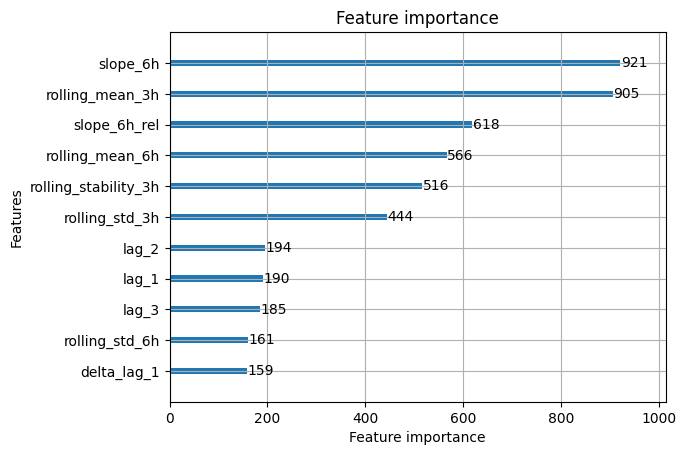

In [76]:
plot_importance(model, max_num_features=20)

In [64]:
X_tr_c2.drop(columns=['col','y','local_mean','local_std','weekday','hour','mean','std','std_rel','range','rolling_stability_24h','rolling_std_24h','rolling_mean_24h','rolling_stability_12h','rolling_std_12h','rolling_mean_12h','rolling_stability_6h'], inplace=True)
X_v_c2.drop(columns=['col','y','weekday','hour','mean','std','std_rel','range','rolling_stability_24h','rolling_std_24h','rolling_mean_24h','rolling_stability_12h','rolling_std_12h','rolling_mean_12h','rolling_stability_6h'], inplace=True)

In [65]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=0.5,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_tr_c2, y_tr_c2.values)
y_pred_train_c2 = model.predict(X_tr_c2)
mae_train_c2 = mean_absolute_error(y_tr_c2, y_pred_train_c2)
print(f" MAE train LGBMRegressor cluster 2 = {mae_train_c2:.4f}")
y_pred_c2 = model.predict(X_v_c2)
mae_c2 = mean_absolute_error(y_v_c2.values, y_pred_c2)
print(f" MAE val LGBM cluster 2 = {mae_c2:.4f}")

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3392
[LightGBM] [Info] Number of data points in the train set: 5300, number of used features: 16
[LightGBM] [Info] Start training from score 0,018998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [66]:
cols_val = Y_val.loc[mask_c2_val, 'col'].values  # <= uniquement celles du cluster 2

y_pred_denorm2 = np.array([
    y * col_stds[col] + col_means[col]
    for y, col in zip(y_pred_c2.flatten(), cols_val)
])

y_val_denorm2 = np.array([
    y * col_stds[col] + col_means[col]
    for y, col in zip(y_v_c2.values.flatten(), cols_val)
])


In [67]:
print(mean_absolute_error(y_val_denorm2, y_pred_denorm2))

145.96257502356235


In [68]:
y_pred_denorm

array([1969.85381375, 1906.30653691,  831.24674078, ...,  352.71128546,
        280.45764169,  270.28814858], shape=(128853,))

## Diagnostic du modèle 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

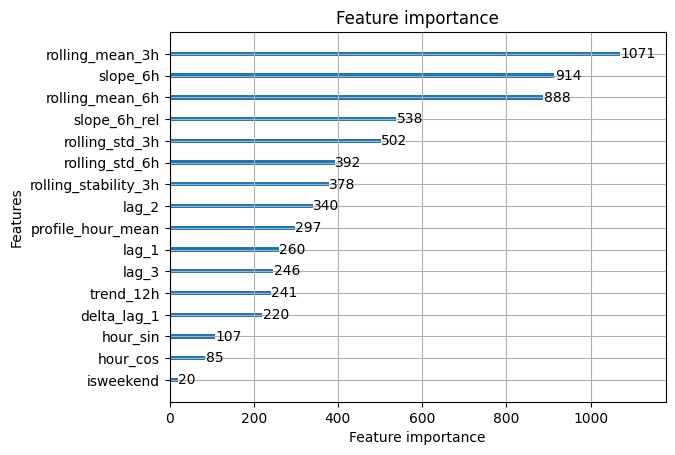

In [69]:
plot_importance(model, max_num_features=30)

In [70]:
X_val['abs_err'] = np.abs(y_pred_denorm - y_val_denorm)
X_val.groupby('cluster')['abs_err'].mean()


KeyError: 'cluster'

In [ ]:
# Prépare les données (sans modifier X_v)
df_plot = pd.DataFrame({
    'hour': X_val['hour'].values,
    'error': np.abs(y_val['y_true'].values - y_pred)
})
grp = df_plot.groupby('hour')['error'].agg(['mean','std','count']).sort_index()
grp['sem'] = grp['std'] / np.sqrt(grp['count'])

# Style et figure
fig, ax = plt.subplots(figsize=(12,5))

x = np.arange(len(grp))
colors = plt.cm.viridis(np.linspace(0.2, 0.85, len(grp)))

# Barplot avec barres d'erreur
bars = ax.bar(x, grp['mean'], yerr=grp['sem'], color=colors, capsize=4, edgecolor='k', alpha=0.9)

# Axes et titres (en français)
ax.set_xticks(x)
ax.set_xticklabels([f"{h:g}" for h in grp.index], rotation=45)
ax.set_xlabel('Heure')
ax.set_ylabel('MAE moyen')
ax.set_title('Erreur absolue moyenne par heure (± erreur standard)')
ax.set_ylim(0, grp['mean'].max() * 1.25)
ax.grid(axis='y', alpha=0.6)

# Annotations au-dessus des barres
for i, (mean, sem) in enumerate(zip(grp['mean'], grp['sem'])):
    ax.text(x[i], mean + sem * 1.6, f"{mean:.0f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()


In [ ]:
# --- Préparation des données ---
df_plot = pd.DataFrame({
    'weekday': X_val['weekday'].values,
    'error': np.abs(y_val['y_true'].values - y_pred)
})

grp = df_plot.groupby('weekday')['error'].agg(['mean','std','count']).sort_index()
grp['sem'] = grp['std'] / np.sqrt(grp['count'])

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(grp))
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(grp)))

bars = ax.bar(x, grp['mean'], yerr=grp['sem'], color=colors, capsize=4, edgecolor='k', alpha=0.9)

# Labels des jours (0 = lundi, 6 = dimanche)
jours = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
ax.set_xticks(x)
ax.set_xticklabels([jours[i] for i in grp.index], rotation=0)
ax.set_xlabel('Jour de la semaine')
ax.set_ylabel('MAE moyen')
ax.set_title('Erreur absolue moyenne par jour de la semaine (± erreur standard)')
ax.set_ylim(0, grp['mean'].max() * 1.25)
ax.grid(axis='y', alpha=0.6)

# Annotations
for i, (mean, sem) in enumerate(zip(grp['mean'], grp['sem'])):
    ax.text(x[i], mean + sem * 1.4, f"{mean:.0f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Entraînement d'un modèle pour chaque cluster

In [ ]:
X_tr = X_train.copy()
X_v = X_val.copy()
y_val = Y_val.copy()

In [ ]:
X_tr["cluster"] = X_tr["col"].map(clusters_labels["cluster"])
X_v["cluster"] = X_v["col"].map(clusters_labels["cluster"])

In [ ]:
X_v["y"] = y_val['y_true']

In [ ]:
# Dictionnaires pour stocker les modèles et résultats
models = {}
results = {}
y_pred_all = {}

# Colonnes inutiles à retirer pour l'entraînement
cols_to_drop_train = [
    'delta_lead_1','col','y','local_mean','local_std','weekday','hour_sin','hour_cos',
    'mean','std','std_rel','range',
    'rolling_stability_24h','rolling_std_24h','rolling_mean_24h',
    'rolling_stability_12h','rolling_std_12h','rolling_mean_12h',
    'rolling_stability_6h'
]
cols_to_drop_val = [
    'delta_lead_1','col','y','weekday','hour_sin','hour_cos','mean','std','std_rel','range',
    'rolling_stability_24h','rolling_std_24h','rolling_mean_24h',
    'rolling_stability_12h','rolling_std_12h','rolling_mean_12h',
    'rolling_stability_6h'
]

# Boucle sur les clusters
for c in sorted(X_tr["cluster"].unique()):
    print(f"\n🚀 Entraînement du modèle pour le cluster {c}")

    # Filtrage train/val
    mask_tr = X_tr["cluster"] == c
    mask_val = X_v["cluster"] == c
    X_tr_c = X_tr[mask_tr].drop(columns=["cluster"])
    X_v_c  = X_v[mask_val].drop(columns=["cluster"])
    y_tr_c = X_tr_c["y"]
    y_v_c  = X_v_c["y"]

    # Nettoyage des colonnes inutiles
    X_tr_c = X_tr_c.drop(columns=cols_to_drop_train, errors='ignore')
    X_v_c  = X_v_c.drop(columns=cols_to_drop_val, errors='ignore')

    # Initialisation du modèle LightGBM
    model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=80,
        min_data_in_leaf=300,
        reg_alpha=0.5,
        reg_lambda=1.0,
        subsample=0.8,
        colsample_bytree=0.6,
        random_state=42,
    )

    # Entraînement
    model.fit(X_tr_c.select_dtypes("number"), y_tr_c.values)
    models[c] = model

    # Évaluation sur le train
    y_pred_train = model.predict(X_tr_c)
    mae_train = mean_absolute_error(y_tr_c, y_pred_train)
    print(f"   🔹 MAE train cluster {c} = {mae_train:.3f}")

    # Évaluation sur la validation
    y_pred_val = model.predict(X_v_c)
    mae_val = mean_absolute_error(y_v_c, y_pred_val)
    print(f"   🔹 MAE val cluster {c} = {mae_val:.3f}")

    # Dénormalisation
    y_pred_denorm = np.array([
        y * col_stds[col] + col_means[col]
        for y, col in zip(y_pred_val.flatten(), Y_val.loc[mask_val, 'col'])
    ])
    y_true_denorm = np.array([
        y * col_stds[col] + col_means[col]
        for y, col in zip(y_v_c.values.flatten(), Y_val.loc[mask_val, 'col'])
    ])
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)

    print(f"   🔹 MAE dénormalisée cluster {c} = {mae_denorm:.3f}")

    # Sauvegarde des résultats
    results[c] = {
        "mae_train": mae_train,
        "mae_val": mae_val,
        "mae_denorm": mae_denorm,
        "n_train": len(X_tr_c),
        "n_val": len(X_v_c)
    }
    y_pred_all[c] = y_pred_denorm

# Résumé global
print("\n📊 Résumé des performances par cluster :")
df_results = pd.DataFrame(results).T
display(df_results)

# MAE globale pondérée (optionnel)
global_mae = np.average(
    df_results["mae_denorm"], 
    weights=df_results["n_val"]
)
print(f"\n🌍 MAE globale pondérée (dénormalisée) = {global_mae:.3f}")

In [ ]:
importances = pd.Series(models[2].feature_importances_, index=X_tr_c2.columns)
importances.nlargest(15).plot(kind='barh', title='Top features cluster 2')

In [ ]:
df_c2_err = pd.DataFrame({
    'hour': X_v_c2['hour'],
    'abs_err': np.abs(y_pred_c2 - y_v_c2)
})
df_c2_err.groupby('hour')['abs_err'].mean().plot(kind='bar', figsize=(10,4))
plt.title("Erreur moyenne par heure - Cluster 2")


### Prédiction du fichier test

In [ ]:
X_test = pd.read_csv(BASE / "X_test.csv", index_col=0,parse_dates=True)

In [ ]:
X_t = X_test.copy()

In [ ]:
col_means = X_test.mean(axis=0)
col_stds = X_test.std().replace(0, 1)  # éviter les divisions par zéro

# On crée une version normalisée du dataset
X_test = (X_test - col_means) / col_stds

In [ ]:
holed_cols = [col for col in X_test.columns if col.startswith("holed_")]
clean_cols = [col for col in X_test.columns if col not in holed_cols]

In [ ]:
X_tt = make_X_test(X_test,holed_cols,n_lags=3,n_leads=3,rolling_windows=[3,6,12,24])

In [ ]:
X_train = make_train_fast(X_test,holed_cols,n_samples = 50000,n_lags=3,n_leads=3,rolling_windows=[3,6,12,24])

In [ ]:
X_topred = X_tt.copy()
X_tr = X_train.copy()
y_train = X_tr["y"]

In [ ]:
X_topred['isweekend'] = X_topred['weekday'].isin([5,6]).astype(int)
X_tr['isweekend'] = X_tr['weekday'].isin([5,6]).astype(int)

In [ ]:
X_tr.drop(columns=['y','col','local_mean','local_std'], inplace=True)
X_tr.drop(columns=['profile_hour_mean','weekday','hour','hour_sin','hour_cos','mean','std','std_rel','range','rolling_stability_24h','rolling_std_24h','rolling_mean_24h','rolling_stability_12h','rolling_std_12h','rolling_mean_12h'], inplace=True)

In [ ]:
X_topred.drop(columns=['col','profile_hour_mean','weekday','hour','hour_sin','hour_cos','mean','std','std_rel','range','rolling_stability_24h','rolling_std_24h','rolling_mean_24h','rolling_stability_12h','rolling_std_12h','rolling_mean_12h'], inplace=True)

In [ ]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=0.5,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_tr, y_train.values)
y_pred_train = model.predict(X_tr)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_topred)

In [ ]:
y_pred_denorm = np.array([
    y * col_stds[col] + col_means[col]
    for y, col in zip(y_pred.flatten(), X_tt['col'])
])

In [ ]:
X_test = X_test*col_stds + col_means
df_imputed = X_test.loc[:,holed_cols]

In [ ]:
for v,(col,index) in zip(y_pred_denorm,zip(X_tt['col'],X_tt.index)) : 
    df_imputed.loc[index,col] = v
    

In [ ]:
df_imputed

In [ ]:
os.makedirs("data/submitted", exist_ok=True)

output_path = "../data/final/df_imputed3.csv"
df_imputed.to_csv(output_path, index=True)

print(f"Fichier sauvegardé dans : {output_path}")